## Dataloader Dev

___
### Packages

In [70]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import numpy as np
import cv2

import os  
from pathlib import Path

import matplotlib.pyplot as plt

from einops import rearrange

___  
### File Organizer  
This function will copy the image and isd files and create a new training dir:
* **training_data**

With 2 sub dirs:
* **training_images**
* **training_isds**

In [2]:
def reorganize_data_files(path_to_parent_data_folder:str, images_folder_list:list, image_quality_list:list) -> None:
    """ 
    Loops over the data folder extracting the original images and their corresponding isd_maps.
    This is needed because the isd_maps folder contains isd_maps for all the processed images and
    we will only use a subset in training, i.e., high quality.

    It generate a new folder called training_data two sub-folders, images and isd_maps
    """
    # Set the dir to the project home
    cwd = Path.cwd()
    project_root_folder = cwd.parent
    
    # Set the destination folders; create if needed
    
    # Root
    training_data_root = str(project_root_folder / "training_data")
    os.makedirs(training_data_root, exist_ok = True)
    
    # Img destination
    training_images_folder = str(project_root_folder / "training_data" / "training_images")
    os.makedirs(training_images_folder, exist_ok = True)
    
    # Img destination
    training_isd_maps_folder = str(project_root_folder / "training_data" / "training_isds")
    os.makedirs(training_isd_maps_folder, exist_ok = True)

    # Go through each of the image folders; i.e., folder_1, folder_2
    for img_folder in images_folder_list:

        # Go through each of the quality folders; i.e, high_quality, low_quality
        for image_quality in image_quality_list:
                
                # Set folder paths
                image_folder = project_root_folder / path_to_parent_data_folder / img_folder / f"processed_{img_folder}" / image_quality
                isd_map_folder = project_root_folder / path_to_parent_data_folder / img_folder / f"processed_{img_folder}" / "isd_maps"
                image_folder_str = str(image_folder)
                isd_map_folder_str = str(isd_map_folder)
                print(image_folder_str)
                print(isd_map_folder_str)

                # Get the images and the isd maps so we can move them to the training folder; make copies
                for image_file in os.listdir(image_folder_str):
                    if image_file.lower().endswith((".tif", ".tiff")):

                        # Step # 1: Get the image of interest
                        img = cv2.imread(os.path.join(image_folder_str, image_file), cv2.IMREAD_UNCHANGED)

                        # Step 2: Get the corresponding ISD map
                        img_name_str = image_file.split(".", 1)[0]
                        img_isd_map_str = img_name_str + "_isd.png"


                        for isd_file in os.listdir(isd_map_folder_str):
                            if isd_file.lower().endswith((".png")):
                                if isd_file == img_isd_map_str:
                                    isd = cv2.imread(os.path.join(isd_map_folder_str, isd_file), cv2.IMREAD_UNCHANGED)

                                    # Set the save names
                                    img_out_file_name = image_file
                                    isd_out_file_name = img_isd_map_str

                                    cv2.imwrite(training_images_folder + "/" + img_out_file_name, img)
                                    cv2.imwrite(training_isd_maps_folder + "/" + isd_out_file_name, isd)
                                    break

In [76]:
image_folder_list = ["folder_1", "folder_3"]
image_quality_list = ["high_quality"]
parent_data_folder_name = "data"

reorganize_data_files(parent_data_folder_name, image_folder_list, image_quality_list)

/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/data/folder_1/processed_folder_1/high_quality
/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/data/folder_1/processed_folder_1/isd_maps
/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/data/folder_3/processed_folder_3/high_quality
/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/data/folder_3/processed_folder_3/isd_maps


___ 
### Get Channel-wise Mean & Std From Training Data  
I am not sure we'll actually need this, but why not?  
And I am not sure about the computation.

In [3]:
def get_channel_wise_mean_and_std(folder_name: str) -> tuple:
    """ 
    Computes the scaled mean and std of each channel in the training set.
    Used for normalization.
    """
    cwd = Path.cwd()
    project_home_dir = cwd.parent
    image_folder = str(project_home_dir / "training_data" / folder_name)

    # Initialize trackers
    channel_sum = np.zeros(3, dtype=np.float64)
    channel_squared_sum = np.zeros(3, dtype=np.float64)
    num_pixels = 0

    # Iterate over all the images in the training dir
    for file in os.listdir(image_folder):
        if file.lower().endswith((".tif", ".tiff")):
            img = cv2.imread(os.path.join(image_folder, file), cv2.IMREAD_UNCHANGED)

            # Scale
            img = img / 65535.0 

            # Update trackers
            channel_sum += np.sum(img, axis = (0, 1))  # For mean
            channel_squared_sum += np.sum(img**2, axis= (0, 1))  # For std
            num_pixels += img.shape[0] * img.shape[1]

    # Compute mean and std
    channel_mean = channel_sum / num_pixels
    channel_std = np.sqrt(
        np.maximum(channel_squared_sum / num_pixels - channel_mean ** 2, 1e-8)  # Avoid dividing by zero??
    )

    return channel_mean, channel_std

In [4]:
folder_name = "training_images"
mean, std = get_channel_wise_mean_and_std(folder_name)
print(f"Mean Channel Vals: {mean}")
print(f"Std Channel Vals: {std}")

Mean Channel Vals: [0.13887039 0.14788628 0.16051863]
Std Channel Vals: [0.16481508 0.16903366 0.18737523]


___ 
### Min and Max Dims from Training Data

In [79]:
def get_min_max_dims(folder_name:str) -> tuple:
    """ 
    Get the min and max dims out of all the images in the training data.
    Used to decide on crop sizes.
    """
    # Pathing
    cwd = Path.cwd()
    project_home_dir = cwd.parent
    image_folder = str(project_home_dir / "training_data" / folder_name)

    # Trackers
    max_height = 0
    max_width = 0
    min_height = np.inf
    min_width = np.inf

    # Iterate over all the images in the training dir
    for file in os.listdir(image_folder):
        if file.lower().endswith((".tif", ".tiff")):

            # Get an image
            img = cv2.imread(os.path.join(image_folder, file), cv2.IMREAD_UNCHANGED)

            # Get img dims
            H, W, C = img.shape 

            # Update trackers
            max_height = max(max_height, H)
            max_width = max(max_width, W)
            min_height = min(min_height, H)
            min_width = min(min_width, W)

    return max_width, max_height, min_width, min_height

In [80]:
max_W, max_H, min_W, min_H = get_min_max_dims("training_images")
print(f"Max Width: {max_W}")
print(f"Max Height: {max_H}")
print(f"Min Width: {min_W}")
print(f"Min Height: {min_H}")

Max Width: 1820
Max Height: 1822
Min Width: 1023
Min Height: 1024


___
### Center Crop Images and Sub-crop Into 4

In [81]:
def center_crop_and_split(folder_name: str, output_folder: str, crop_size:int, sub_crop_size:int):
    """
    Center crop all images and then divide the center crop into four 224x224 sub-crops.
    """
    # Pathing
    cwd = Path.cwd()
    project_home_dir = cwd.parent
    image_folder = str(project_home_dir / "training_data" / folder_name)
    output_dir = Path(project_home_dir / "training_data" / output_folder)
    output_dir.mkdir(parents=True, exist_ok=True)
    output_dir_str = str(output_dir)

    # Iterate over all the images in the folder
    for file in os.listdir(image_folder):
        if file.lower().endswith((".tif", ".tiff", ".png")):
            # Read the image
            img = cv2.imread(os.path.join(image_folder, file), cv2.IMREAD_UNCHANGED)

            # Get image dimensions
            H, W = img.shape[:2]

            # Calculate center crop
            start_x = (W - crop_size) // 2
            start_y = (H - crop_size) // 2
            end_x = start_x + crop_size
            end_y = start_y + crop_size

            # Extract center crop
            center_crop = img[start_y:end_y, start_x:end_x]

            # Divide the center crop into 4 (224x224) sub-crops
            for i in range(2):  # Rows (top and bottom)
                for j in range(2):  # Columns (left and right)
                    x_start = j * sub_crop_size
                    y_start = i * sub_crop_size
                    x_end = x_start + sub_crop_size
                    y_end = y_start + sub_crop_size

                    # Extract sub-crop
                    sub_crop = center_crop[y_start:y_end, x_start:x_end]

                    # Determine save path
                    if file.lower().endswith(".png"):
                        sub_crop_filename = f"{file.split('.')[0]}_{i}_{j}.png"
                    else:
                        sub_crop_filename = f"{file.split('.')[0]}_{i}_{j}.tif"
                    cv2.imwrite(os.path.join(output_dir_str, sub_crop_filename), sub_crop)


In [82]:
folder_name = "training_images"
output_folder = "training_images_cropped"
crop_size = 448
sub_crop_size = 224
center_crop_and_split(folder_name, output_folder, crop_size, sub_crop_size)

In [83]:
folder_name = "training_isds"
output_folder = "training_isds_cropped"
crop_size = 448
sub_crop_size = 224
center_crop_and_split(folder_name, output_folder, crop_size, sub_crop_size)

In [40]:
class ImageDatasetGenerator(Dataset):
    def __init__(self, image_folder:str, guidance_folder:str, transform=None):
        """
        Generates two data sets; images and isd_maps

        Args:
            image_folder (str): Folder name of images
            guidance_folder (str): Folder name of isd maps
            transform (callable): A function/transform to apply to the images. Optional, default = None.
        """
        # Set paths to images
        self.image_paths = [
            os.path.join(image_folder, file)
            for file in os.listdir(image_folder)
            if file.lower().endswith(('.tif', '.tiff'))
        ]

        # Set paths to isds
        self.guidance_paths = [
            os.path.join(guidance_folder, file)
            for file in os.listdir(guidance_folder)
            if file.lower().endswith(".png")
        ]
        
        # Sort to ensure they match
        self.image_paths.sort()
        self.guidance_paths.sort()

        # Check they are same length
        assert len(self.image_paths) == len(self.guidance_paths)
        print("Assertion Passed!!! We have the number of images and isd maps")

        self.transform = transform

    def __len__(self):
        """ 
        Returns the number of image pairs. 
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """ 
        Get the primary image and its corresponding guidance image.
        """
        # Load primary image
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        print(f"Loading: {img_path}")

        # Load guidance image
        guidance_path = self.guidance_paths[idx]
        guidance_image = Image.open(guidance_path)

        # Perform transforms
        if self.transform:
            image = self.transform(image)
            guidance_image = self.transform(guidance_image)

        # Return the pair of images
        return image, guidance_image


In [41]:
# Transforms -- We can add augmentations here
transform = transforms.Compose([ 
                transforms.ToTensor(),        
                transforms.Normalize(mean = mean, std = std)
                            ])

In [42]:
# Folder paths
image_folder = "/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_images_cropped"
isd_map_folder = "/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_isds_cropped"

# Create dataset
dataset = ImageDatasetGenerator(image_folder, isd_map_folder, transform)

# Create dataloader
# Shuffle equals false for now for testing
# drop last creates only full batches
dataloader = DataLoader(dataset, batch_size = 4, shuffle = False, drop_last = True)

Assertion Passed!!! We have the number of images and isd maps


In [45]:
for idx, (images, isds) in enumerate(dataloader):
    print(f"Batch {idx}: Images shape: {images.shape}")
    print(f"Batch {idx}: Isds shape: {isds.shape}")
    test_batch_images = images
    test_batch_isds = isds
    if idx == 0:
        break

Loading: /Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_images_cropped/Adari_Girish_000_0_0.tif
Loading: /Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_images_cropped/Adari_Girish_000_0_1.tif
Loading: /Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_images_cropped/Adari_Girish_000_1_0.tif
Loading: /Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_images_cropped/Adari_Girish_000_1_1.tif
Batch 0: Images shape: torch.Size([4, 3, 224, 224])
Batch 0: Isds shape: torch.Size([4, 3, 224, 224])


___ 
### Inspect

The colors are messed up because these display function are not made correctly yet. 

In [71]:
def display_batch_images(images, grid_size:tuple = (2, 2), title:str = "Batch Images") -> None:
    """
    Displays a batch of images.

    Batch size need to match the product of grid size.
    """
    # Rearrange dims for plotting
    images = rearrange(images, "b c h w -> b h w c")
    
    # Create a figure
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize = (10, 10))
    fig.suptitle(title, fontsize = 16, weight = "bold")
    
    for i, ax in enumerate(axes.flat):
        if i < images.size(0):
            
            # Convert the image to numpy for plotting
            img = images[i].numpy()

            # Normalize
            img = (img - img.min()) / (img.max() - img.min())  # Rescale to [0, 1]
            
            # Display the image
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off') 
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for title
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


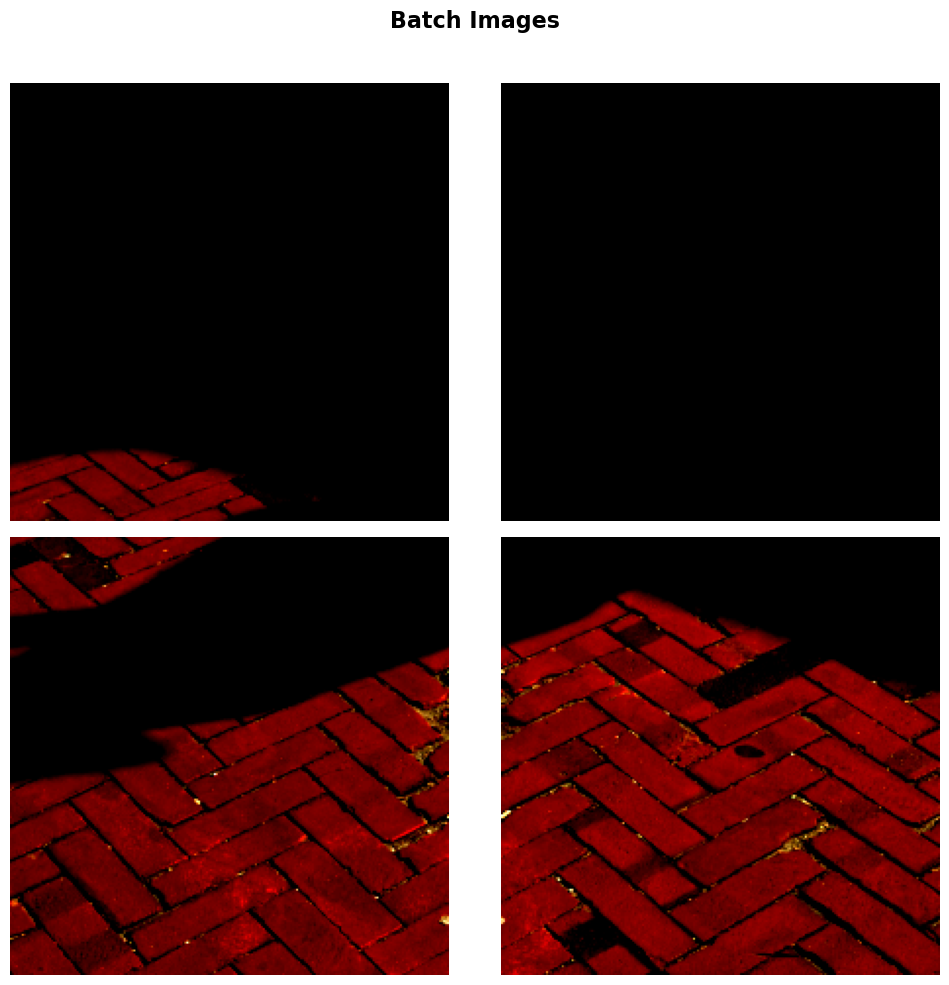

In [72]:
display_batch_images(test_batch_images)

In [62]:
def display(img_path:str):
    """ 
    Displays one image
    """
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    img = (img - img.min()) / (img.max() - img.min()) 
    plt.figure(figsize = (10, 10))
    plt.imshow(img)
    plt.axis("off")

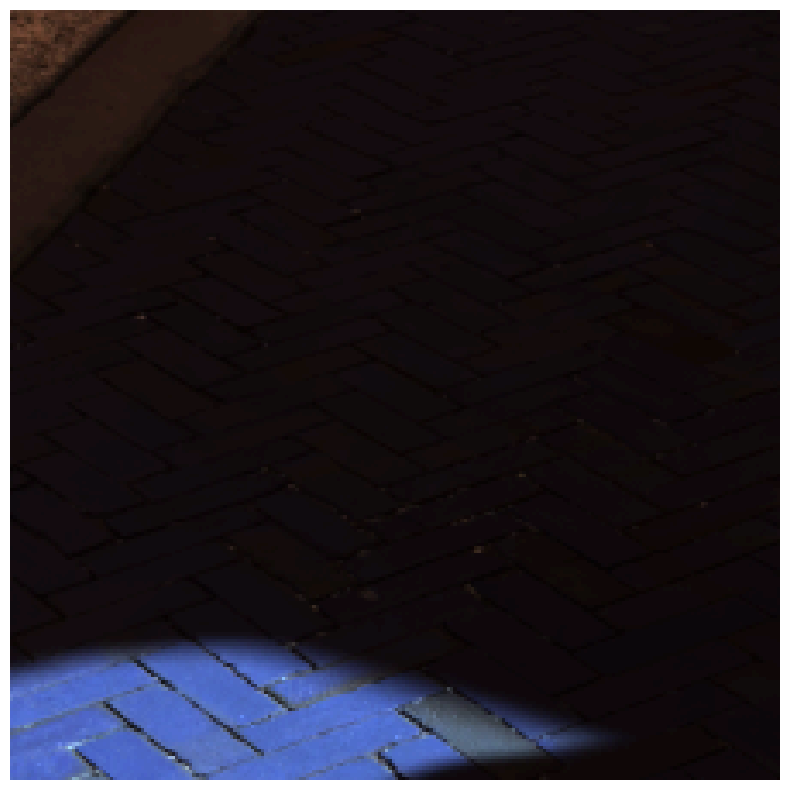

In [63]:
display("/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_images_cropped/Adari_Girish_000_0_0.tif")

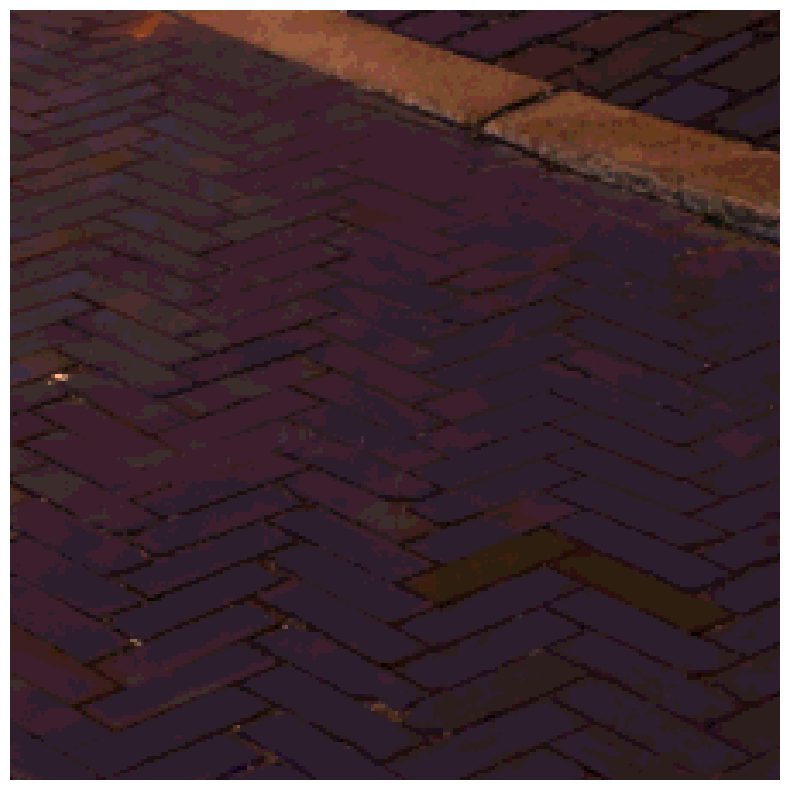

In [64]:
display("/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_images_cropped/Adari_Girish_000_0_1.tif")

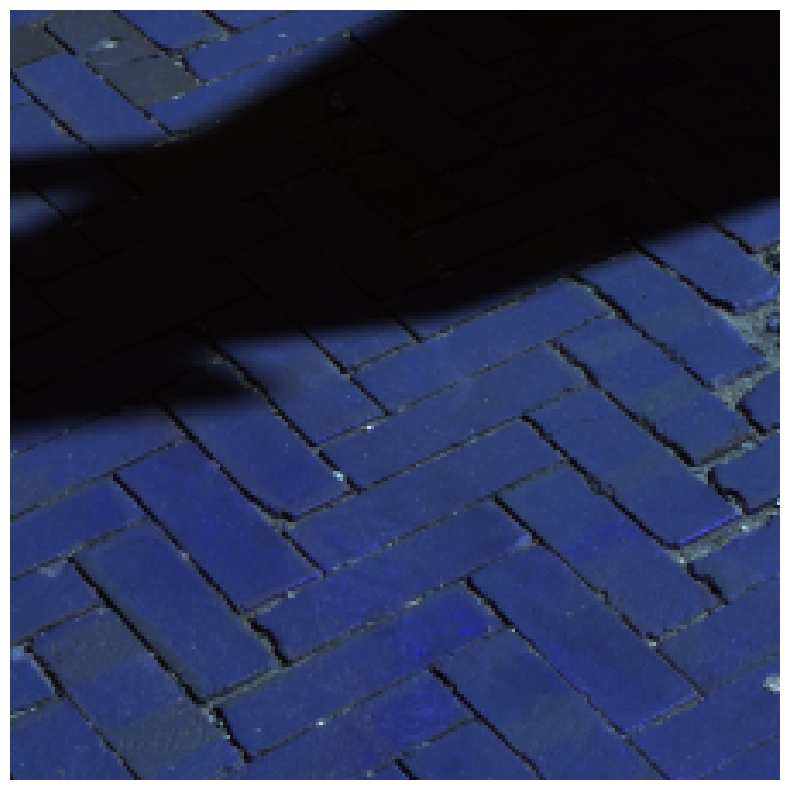

In [65]:
display("/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_images_cropped/Adari_Girish_000_1_0.tif")

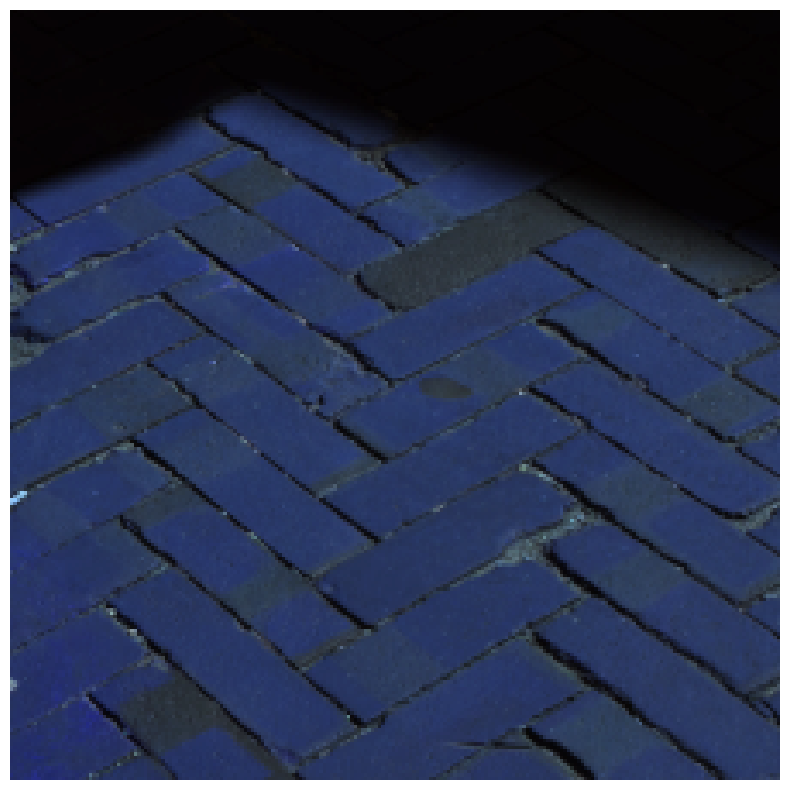

In [66]:
display("/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_images_cropped/Adari_Girish_000_1_1.tif")

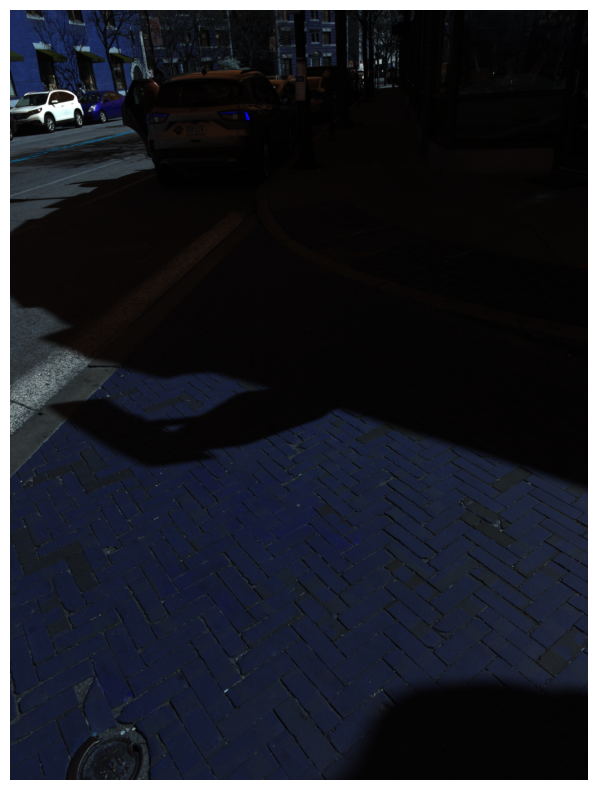

In [67]:
display("/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/training_data/training_images/Adari_Girish_000.tif")